Loading results from 2025_11_16-22_50_50...
Found 21 recordings for mouse1
Found 21 recordings for mouse2

--- Analysis DataFrame Created ---
                                               video  frame  mouse1_syllable  \
0  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      0               16   
1  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      1               16   
2  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      2               16   
3  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      3               16   
4  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      4               16   

   mouse2_syllable  
0               14  
1               14  
2               14  
3               14  
4               14  

Total frames in analysis: 564933
--- Building Lag Matrix ---
Calculating 20x20 matrix (P(M2 | M1 onset) within 1.0s)...
...matrix built in 16.92 seconds.

Lag Matrix (Top 20 Syllables):

(Generating lag matrix heatmap...)


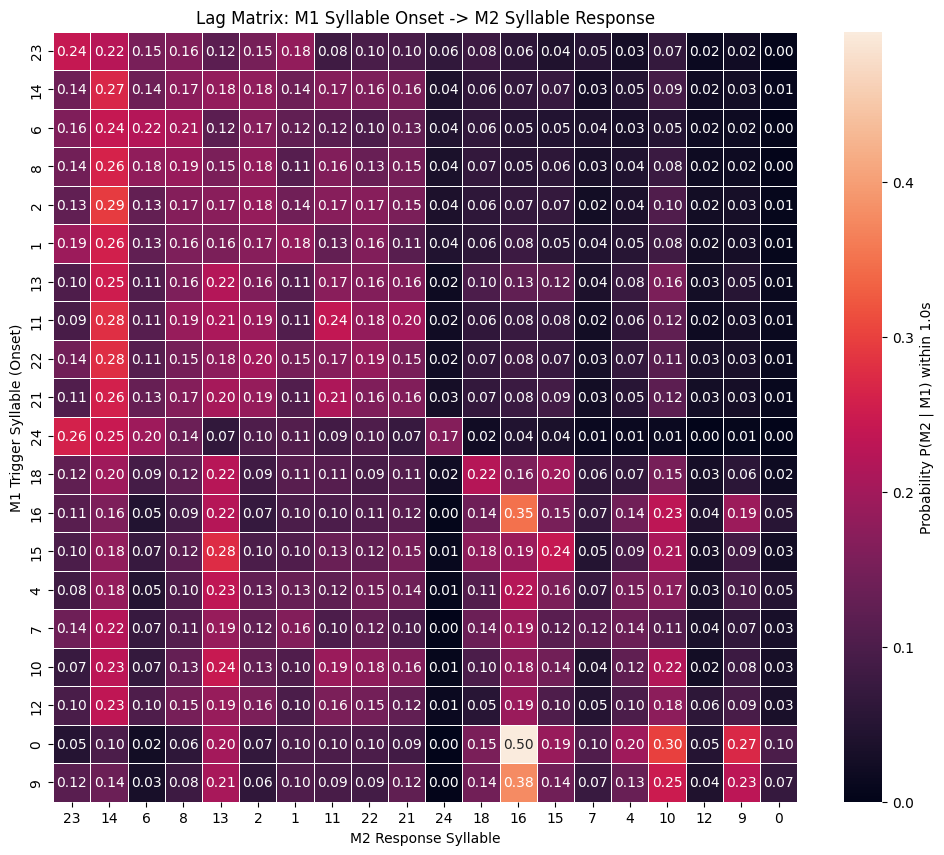


--- Running Significance Tests for Top 5 Pairs ---
Found top 5 pairs to test:
M1 Trigger Syllable (Onset)  M2 Response Syllable
0                            16                      0.496933
9                            16                      0.377850
16                           16                      0.347622
0                            10                      0.300613
2                            14                      0.294247
dtype: float64


Testing Pair: (M1 Syll: 0) -> (M2 Syll: 16)
    ...running 500 shuffles...
    Real Probability:     0.4969
    Avg. Shuffled Prob:   0.0893
    P-Value:              0.0020
    >> Verdict: STATISTICALLY SIGNIFICANT (p < 0.05)
------------------------------
Testing Pair: (M1 Syll: 9) -> (M2 Syll: 16)
    ...running 500 shuffles...
    Real Probability:     0.3779
    Avg. Shuffled Prob:   0.0892
    P-Value:              0.0020
    >> Verdict: STATISTICALLY SIGNIFICANT (p < 0.05)
------------------------------
Testing Pair: (M1 Syll: 16) 

In [5]:
import keypoint_moseq as kpms
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import groupby

project_dir = '/Users/yinazhou/DeepLabCut/examples/DeepLabCut/examples/11_1_identity_true'
model_name = '2025_11_16-22_50_50' # folder with results.h5

FPS = 30

# How far to look ahead for a response (in seconds)
LAG_WINDOW_SEC = 1.0

# How many top syllables to include in all to all matrix
TOP_N_SYLLABLES = 20

# How many of the most probable pairs to run the significance test on
TOP_K_PAIRS_TO_TEST = 5

# How many shuffles for the permutation test
N_SHUFFLES = 500

print(f"Loading results from {model_name}...")
results = kpms.load_results(project_dir, model_name)

# separate recordings by animal
all_recording_keys = list(results.keys())
mouse1_recordings = sorted([key for key in all_recording_keys if key.endswith('_mouse1')])
mouse2_recordings = sorted([key for key in all_recording_keys if key.endswith('_mouse2')])

print(f"Found {len(mouse1_recordings)} recordings for mouse1")
print(f"Found {len(mouse2_recordings)} recordings for mouse2")

# build paired dataframe for analysis
all_paired_data = []

for m1_key in mouse1_recordings:
    base_name = m1_key.replace('_mouse1', '')
    m2_key = base_name + '_mouse2'
    
    if m2_key in results:
        m1_syllables = results[m1_key]['syllable']
        m2_syllables = results[m2_key]['syllable']
        
        min_len = min(len(m1_syllables), len(m2_syllables))
        
        video_df = pd.DataFrame({
            'video': base_name,
            'frame': np.arange(min_len),
            'mouse1_syllable': m1_syllables[:min_len],
            'mouse2_syllable': m2_syllables[:min_len]
        })
        all_paired_data.append(video_df)

master_df = pd.concat(all_paired_data, ignore_index=True)

print("\n--- Analysis DataFrame Created ---")
print(master_df.head())
print(f"\nTotal frames in analysis: {len(master_df)}")



#analysis functions
def find_lagged_responses(df, trigger_mouse, trigger_syllable, response_mouse, response_syllable, window_frames):
    """
    Finds P(Response | Trigger) within a window, based on ONSET of trigger.
    
    This function is a "silent" tool - it returns values without printing.
    """
    trigger_col = f'{trigger_mouse}_syllable'
    response_col = f'{response_mouse}_syllable'
    
    # Get the frame indices where the *trigger syllable starts* (onset)
    trigger_series = df[trigger_col]
    trigger_indices = df.index[
        (trigger_series == trigger_syllable) & 
        (trigger_series.shift(1) != trigger_syllable)
    ]
    
    if len(trigger_indices) == 0:
        return 0.0, 0, 0 # Prob, hits, total

    hit_count = 0
    for idx in trigger_indices:
        window_start = idx + 1
        window_end = idx + window_frames
        
        if window_start >= len(df):
            continue
            
        response_window = df.loc[window_start:window_end, response_col]
        
        if (response_window == response_syllable).any():
            hit_count += 1
            
    prob = hit_count / len(trigger_indices)
    return prob, hit_count, len(trigger_indices)


def run_permutation_test(df, trigger_mouse, trigger_syll, response_mouse, response_syll, window_frames, n_shuffles):
    """
    Runs a permutation test by "rolling" the response mouse's data.
    """
    # calculate the real observed probability
    real_prob, _, _ = find_lagged_responses(
        df, trigger_mouse, trigger_syll, response_mouse, response_syll, window_frames
    )
    
    if real_prob == 0.0:
        return 0.0, 0.0, [], 1.0 # p_val, real_prob, null_dist, avg_shuffled
        
    null_distribution = []
    shuffled_df = df.copy()
    response_col = f"{response_mouse}_syllable"
    
    print(f"    ...running {n_shuffles} shuffles...")
    
    # run N shuffles to create the null distribution
    for i in range(n_shuffles):
        # create a large, random shift (roll)
        random_shift = np.random.randint(1000, len(shuffled_df) - 1000)
        
        # roll the response mouse's data
        shuffled_df[response_col] = np.roll(df[response_col], shift=random_shift)
        
        shuffled_prob, _, _ = find_lagged_responses(
            shuffled_df, trigger_mouse, trigger_syll, response_mouse, response_syll, window_frames
        )
        null_distribution.append(shuffled_prob)

    # calculate the p-value
    n_exceeding = np.sum(np.array(null_distribution) >= real_prob)
    p_value = (n_exceeding + 1) / (n_shuffles + 1)
    
    return p_value, real_prob, np.mean(null_distribution), null_distribution

print("--- Building Lag Matrix ---")

# 1. Get the top N syllables
m1_syllable_counts = master_df['mouse1_syllable'].value_counts()
m2_syllable_counts = master_df['mouse2_syllable'].value_counts()

m1_top_syllables = m1_syllable_counts.head(TOP_N_SYLLABLES).index
m2_top_syllables = m2_syllable_counts.head(TOP_N_SYLLABLES).index

# 2. Calculate window in frames
window_f = int(LAG_WINDOW_SEC * FPS)

# 3. Create the empty matrix
lag_matrix = pd.DataFrame(index=m1_top_syllables, columns=m2_top_syllables, dtype=float)
lag_matrix.index.name = "M1 Trigger Syllable (Onset)"
lag_matrix.columns.name = "M2 Response Syllable"

# 4. Fill the matrix
print(f"Calculating {TOP_N_SYLLABLES}x{TOP_N_SYLLABLES} matrix (P(M2 | M1 onset) within {LAG_WINDOW_SEC}s)...")
start_time = time.time()

for m1_syll in m1_top_syllables:
    for m2_syll in m2_top_syllables:
        prob, _, _ = find_lagged_responses(
            df=master_df,
            trigger_mouse='mouse1',
            trigger_syllable=m1_syll,
            response_mouse='mouse2',
            response_syllable=m2_syll,
            window_frames=window_f
        )
        lag_matrix.loc[m1_syll, m2_syll] = prob

print(f"...matrix built in {time.time() - start_time:.2f} seconds.")

# 5. Display the matrix
print(f"\nLag Matrix (Top {TOP_N_SYLLABLES} Syllables):")
print(lag_matrix.style.format("{:.2f}").background_gradient(cmap='viridis'))


print("\n(Generating lag matrix heatmap...)")
plt.figure(figsize=(12, 10))
sns.heatmap(
    lag_matrix,
    cmap='rocket', # 'rocket' or 'viridis' are good
    annot=True, 
    fmt=".2f", # Format to 2 decimal places
    linewidths=.5,
    cbar_kws={'label': f'Probability P(M2 | M1) within {LAG_WINDOW_SEC}s'}
)
plt.title(f'Lag Matrix: M1 Syllable Onset -> M2 Syllable Response')
plt.show()


print(f"\n--- Running Significance Tests for Top {TOP_K_PAIRS_TO_TEST} Pairs ---")

# 1. Find the top K pairs from the matrix
all_pairs = lag_matrix.stack()
top_k_pairs = all_pairs.sort_values(ascending=False).head(TOP_K_PAIRS_TO_TEST)

print(f"Found top {TOP_K_PAIRS_TO_TEST} pairs to test:")
print(top_k_pairs)
print("\n" + "="*40 + "\n")

results = []

# 2. Loop through and test each one
for (m1_syll, m2_syll), real_prob in top_k_pairs.items():
    
    print(f"Testing Pair: (M1 Syll: {m1_syll}) -> (M2 Syll: {m2_syll})")
    
    p_val, _, avg_shuffled, _ = run_permutation_test(
        master_df,
        'mouse1', m1_syll,
        'mouse2', m2_syll,
        window_f,
        N_SHUFFLES
    )
    
    print(f"    Real Probability:     {real_prob:.4f}")
    print(f"    Avg. Shuffled Prob:   {avg_shuffled:.4f}")
    print(f"    P-Value:              {p_val:.4f}")
    
    verdict = "STATISTICALLY SIGNIFICANT" if p_val < 0.05 else "NOT significant"
    print(f"    >> Verdict: {verdict} (p < 0.05)")
    print("-" * 30)
    
    results.append({
        'm1_syll': m1_syll,
        'm2_syll': m2_syll,
        'real_prob': real_prob,
        'avg_shuffled': avg_shuffled,
        'p_value': p_val,
        'significant': (p_val < 0.05)
    })

print("\n" + "="*40)
print("--- FINAL SUMMARY OF SIGNIFICANT PAIRS ---")
print("="*40)

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4f"))

